## Data import - Specifying custom camera information

In order to use all features of pyplis, certain specifications related to camera
and image acquisition need to be defined. Basic information about the camera
(e.g. detector specifications, filter setup, file type). If applicatble, the `Camera` class also includes information about the file naming convention used, which will enable metadata access (such as acquisition time, or which filter is used) directly from the image file names. This tutorial introduces the `Camera` class and
how to set up your custom camera type based on your data format, including definitions of your file naming convention.

In [1]:
import pyplis
pyplis.change_loglevel(pyplis.logger, 'exception', update_fmt=True, fmt_debug=True)
pyplis.change_loglevel(pyplis.print_log, 'warning', update_fmt=True, fmt_debug=False)

### Specifying your file naming convention

At the very beginning of the analysis, the images need to be imported and
separated by image type (e.g. on-band plume, off-band plume, dark, offset, on /
off-band cell calibration). *pyplis* can perform an automatic separation of the different image types (e.g. if all image types are stored in the same directory), given that information about the image type is encoded in the image file names and that the relevant decoding information is specified in the corresponding `Camera` class. 

In order to use this automated separation for a given dataset (e.g. a single folder `IMG_DIR` containing images of all types) it is required that the image type can be identified from the file names.

The relevant information for identifying different image types (e.g. plume
on-band, dark, offset) can be specified using either of the following two
classes:

1. `Filter`: specifies file access information for all image types that are **NOT** dark or offset images (e.g. on / off images plume / background)
2. `DarkOffsetInfo`: specifies different types of dark images and offset images.

In [2]:
f = pyplis.Filter()
print(f)


Filter
-----------
id: on
type: on
acronym: default
meas_type_acro: default
center_wavelength: nan



In [3]:
d = pyplis.utils.DarkOffsetInfo()
print(d)


DarkOffsetInfo
---------------------------------
ID: dark
Type: dark
Acronym: 
Meas type acronym: 
Read gain: 0



Such a collection of `Filter` and `DarkOffsetInfo` objects is then
stored within a `Camera` object.

These information is used to separate the individual image types when creating a
`Dataset` object. The latter searches all valid image files in a given
folder `IMG_DIR` and creates `ImgList` objects for each `Filter`
and `DarkImgList` objects for each `DarkOffsetInfo` object defined
in the `Camera`. Each of these lists is then filled with the file paths
of the corresponding image type located in ``IMG_DIR``. The `Camera`
object furthermore includes relevant specs of the camera (e.g. pixel geometry,
lens).

The following list provides an overview of relevant parameters for filename
access information using exemplary filenames of the ECII camera type.


### The ECII camera standard

In the following, an exemplary `Camera` class is specified based on the
ECII-camera standard and file naming convention.

To start with, an empty `Camera` instance is created:

In [4]:
cam = pyplis.Camera()
print(cam)

None, serno. 9999
-------------------------
cam_id: None
delim: .
time_info_pos: None
time_info_str: 
filter_id_pos: None
texp_pos: None
texp_unit: ms
file_type: None
main_filter_id: None
meas_type_pos: None
darkcorr_opt: 0
focal_length: None
pix_height: None
pix_width: None
pixnum_x: None
pixnum_y: None
reg_shift_off: [0.0, 0.0]
io_opts: {}
image_import_method: None

Dark & offset info
------------------------

Filters
----------------------
on, type: on (default): nan nm
Default Filter: on

Geometry info
----------------------
lon: None
lat: None
altitude: None
azim: None
azim_err: None
elev: None
elev_err: None
alt_offset: 0.000



If you wish to store the camera as default you need to specify a unique camera
ID (string) which is not yet used for any of the pyplis default cameras stored
in the file [cam_info.txt](https://github.com/jgliss/pyplis/blob/master/pyplis/data/cam_info.txt). You can check all existing IDs using:

In [5]:
print(pyplis.inout.get_all_valid_cam_ids())

['hdcam', 'hd', 'HD', 'HDCam', 'ecII', 'ec2', 'ECII', 'EC2', 'EnvicamII', 'PCO', 'pco', 'pco.ultraviolet', 'PCO.ultraviolet', 'hd_new', 'usgs', 'usgs_12mm', 'usgs', 'usgs_9mm', 'ecII_new_test', 'comtessa', 'nilu', 'NILU', '', 'ecII_test']


Let's call our new camera "ecII_test":

In [6]:
cam.cam_id = "ecII_test"

Now specify some relevant attributes of the camera, starting with the image file
type:

In [7]:
cam.file_type = "fts"

You can also provide information about detector and camera lens:

In [8]:
cam.focal_length = 25e-3 #m

# Detector geometry
cam.pix_height = 4.65e-6 # pixel height in m
cam.pix_width = 4.65e-6 # pixel width in m
cam.pixnum_x = 1344
cam.pixnum_y = 1024

In the following, the camera file naming convention is specified. This enables
to extract certain information from the image file names (e.g. image acq. time,
image type, exposure time).

Start with setting the file name delimiter of your file naming convention:

In [9]:
cam.delim = "_"

Based on that, specify the position of acquisition time (and date) in the image
file names after splitting with delimiter:

In [10]:
cam.time_info_pos = 3

The acq. time strings in the file names need to be converted into ``datetime``
objects thus, specify the string for internal conversion (is done using
`datetime.strptime`):

In [11]:
cam.time_info_str = "%Y%m%d%H%M%S%f"

If the file name also includes the image exposure time, this can also be
specified:

In [12]:
cam.texp_pos = "" #the ECII does not...

as well as the unit (choose from "s" or "ms" if applicable):

In [13]:
cam.texp_unit = ""

Furthermore, the image type identification can (and should) be specified in the
camera, in order to make life easier. This ensures, that images of different
types (e.g. on / off-band, dark, offset) can be identified and separated
directly from the filename. The relevant information is specified in a
collection of `Filter` and `DarkOffsetInfo` objects.
Let's start off with defining the different image access types for on and
off-band images (these are stored in `Filter` objects, while dark /
offset image access information is stored in `DarkOffsetInfo` objects,
follows below):

In [14]:
# On-band images
on = pyplis.Filter(id="on", type="on", acronym="F01",
                   meas_type_acro="F01", center_wavelength=310)
# Off-band images
off = pyplis.Filter(type="off", acronym="F02",
                    meas_type_acro="F02", center_wavelength=330)

Now add the two filters to the camera (i.e. put them into a list and assign  it
to the camera):

In [15]:
cam.filter_setup['on'] = on
cam.filter_setup['off'] = off

Tell the camera, which of the filters is the "central" filter for the emission
rate analysis (usually "on"):

In [16]:
cam.main_filter_id = "on"

The latter information is used for internal linking of image lists within a
`Dataset` object, for instance, if the camera contains multiple
``type="on"`` filters (i.e. on-band SO2).

Note: The parameter ``main_filter_id`` is irrelevant for standard setups like here
(i.e. one on and one off-band filter).

The filter setup specifies how actual plume (or background) images can be accessed from the filenames. If you have recorded dark images and if these dark images are identifiable via the filename in a similar manner than the on / off images, you can add these information to the `Camera` as well. The interface to be used here is the class `DarkOffsetInfo`, which is similar to the `Filter`class. The ECII camera used in this example has the possibility to enhance the sensitivity by activating mode *gain=high* (similar to ISO in normal cameras). These high-gain images are more noisy but have shorter aqcuisition times at low light conditions. 

The automatic dark / offset image acquisition routine of the camera takes 2 dark images, one at the shortest and one at the longest possible exposure, both for low and high gain (so 4 images in total). The information about which one of the four images is used, is encoded in the filename as well via 4 identifiers:

- D0L: Dark image, shortest exposure, low gain
- D1L: Dark image, longest exposure, low gain
- D0H: Dark image, shortest exposure, high gain
- D1H: Dark image, longest exposure, high gain

This can be setup as follows:

In [17]:
offset_low_gain  = pyplis.DarkOffsetInfo(id="offset0",type="offset",
                                        acronym="D0L",
                                        meas_type_acro="D0L",
                                        read_gain=0)

offset_high_gain = pyplis.DarkOffsetInfo(id="offset1",type="offset",
                                         acronym="D0H", read_gain=1)
dark_low_gain    = pyplis.DarkOffsetInfo(id="dark0",type="dark",
                                         acronym="D1L", read_gain=0)
dark_high_gain   = pyplis.DarkOffsetInfo(id="dark1",type="dark",
                                         acronym="D1H", read_gain=1)

cam.dark_info = [offset_low_gain, offset_high_gain,
                 dark_low_gain, dark_high_gain]

You might have recognised, that in the last 3 `DarkOffsetInfo`
objects, the meas_type_acro was not specified. This is because it is actually
irrelevant for the ECII camera which does not include a sub string specifying
different measurement modi like, for instance, the HD-Custom camera (i.e. K, M,
D). In fact, specifying `meas_type_acro` is not mandatory.

Now that all different image types are specified, the camera needs to know where
to find the actual information in the file names (after splitting using ``delim``).
The position of the strings specified in the attribute ``acronym`` (see
definitions of the ``Filter`` and ``DarkOffsetInfo`` objects above) can be set
using:

In [18]:
cam.acronym_pos = 4

The position of the strings specified in attribute ``meas_type_acro``:

In [19]:
cam.meas_type_acro_pos = 4

**Note**: If ``meas_type_acro`` is irrelevant (like for this camera) it is required to
be set equal to ``acronym_pos``.

Furthermore, if automatic dark (and offset) correction is supposed to be performed during the analysis, it can be specified in the camera, how this is supposed to be done: *pyplis* includes two options for that, details about these can be found in [Appendix C in Gliss et al., 2017](https://www.mdpi.com/2076-3263/7/4/134/htm#app3-geosciences-07-00134).
The ECII uses option 1:

In [20]:
cam.DARK_CORR_OPT = 1

That's it! You might want to check if everything is in place::

In [21]:
print(cam)

ecII_test, serno. 9999
-------------------------
cam_id: ecII_test
delim: _
time_info_pos: 3
time_info_str: %Y%m%d%H%M%S%f
filter_id_pos: 4
texp_pos: 
texp_unit: 
file_type: fts
main_filter_id: on
meas_type_pos: 4
darkcorr_opt: 0
focal_length: 0.025
pix_height: 4.65e-06
pix_width: 4.65e-06
pixnum_x: 1344
pixnum_y: 1024
reg_shift_off: [0.0, 0.0]
io_opts: {}
image_import_method: None

Dark & offset info
------------------------
ID: offset0, type: offset, acronym: D0L, meas_type_acro: D0L,read_gain: 0
ID: offset1, type: offset, acronym: D0H, meas_type_acro: D0H,read_gain: 1
ID: dark0, type: dark, acronym: D1L, meas_type_acro: D1L,read_gain: 0
ID: dark1, type: dark, acronym: D1H, meas_type_acro: D1H,read_gain: 1

Filters
----------------------
on, type: on (F01): 310 nm
off, type: off (F02): 330 nm
Default Filter: on

Geometry info
----------------------
lon: None
lat: None
altitude: None
azim: None
azim_err: None
elev: None
elev_err: None
alt_offset: 0.000



If you are happy, you might want to check if the data access from the file names
works. Let's find some images (take the first 4):

In [22]:
import glob, os
files = glob.glob('{}/data/testdata_minimal/images/*.fts'.format(pyplis.__dir__))[:4]
files

['c:\\users\\jonas\\jonas\\repos\\pyplis\\pyplis/data/testdata_minimal/images\\EC2_1106307_1R02_2015091606454457_F01_Etna.fts',
 'c:\\users\\jonas\\jonas\\repos\\pyplis\\pyplis/data/testdata_minimal/images\\EC2_1106307_1R02_2015091606454717_F02_Etna.fts',
 'c:\\users\\jonas\\jonas\\repos\\pyplis\\pyplis/data/testdata_minimal/images\\EC2_1106307_1R02_2015091606593268_D0L_Etna.fts',
 'c:\\users\\jonas\\jonas\\repos\\pyplis\\pyplis/data/testdata_minimal/images\\EC2_1106307_1R02_2015091606593410_D1L_Etna.fts']

Now loop over these images and print the metainfo retrieved from the filenames:

In [23]:
for file in files:
    fname = os.path.basename(file)
    acq_time, filter_id, meas_type, texp, warnings = cam.get_img_meta_from_filename(file)
    print('File: {}\n'
          'Acq. time: {}\n'
          'filter ID: {}\n'
          'meas type: {}\n'
          'Exp. time: {}\n'.format(fname, acq_time, filter_id, meas_type, texp))

File: EC2_1106307_1R02_2015091606454457_F01_Etna.fts
Acq. time: 2015-09-16 06:45:44.570000
filter ID: F01
meas type: F01
Exp. time: None

File: EC2_1106307_1R02_2015091606454717_F02_Etna.fts
Acq. time: 2015-09-16 06:45:47.170000
filter ID: F02
meas type: F02
Exp. time: None

File: EC2_1106307_1R02_2015091606593268_D0L_Etna.fts
Acq. time: 2015-09-16 06:59:32.680000
filter ID: D0L
meas type: D0L
Exp. time: None

File: EC2_1106307_1R02_2015091606593410_D1L_Etna.fts
Acq. time: 2015-09-16 06:59:34.100000
filter ID: D1L
meas type: D1L
Exp. time: None



You might also test it for a whole dataset of images located in the image directorz and check if pyplis can identify the different image types. You can do this, for instance, by creating a `Dataset` object. First, create a
measurement setup with minimum information:

In [24]:
meas_setup = pyplis.MeasSetup(base_dir=os.path.dirname(files[0]), camera=cam)
print(meas_setup)


Meteorology info
-----------------------
dir: None
dir_err: None
vel: None
vel_err: None

ecII_test, serno. 9999
-------------------------
cam_id: ecII_test
delim: _
time_info_pos: 3
time_info_str: %Y%m%d%H%M%S%f
filter_id_pos: 4
texp_pos: 
texp_unit: 
file_type: fts
main_filter_id: on
meas_type_pos: 4
darkcorr_opt: 0
focal_length: 0.025
pix_height: 4.65e-06
pix_width: 4.65e-06
pixnum_x: 1344
pixnum_y: 1024
reg_shift_off: [0.0, 0.0]
io_opts: {}
image_import_method: None

Dark & offset info
------------------------
ID: offset0, type: offset, acronym: D0L, meas_type_acro: D0L,read_gain: 0
ID: offset1, type: offset, acronym: D0H, meas_type_acro: D0H,read_gain: 1
ID: dark0, type: dark, acronym: D1L, meas_type_acro: D1L,read_gain: 0
ID: dark1, type: dark, acronym: D1H, meas_type_acro: D1H,read_gain: 1

Filters
----------------------
on, type: on (F01): 310 nm
off, type: off (F02): 330 nm
Default Filter: on

Geometry info
----------------------
lon: None
lat: None
altitude: None
azim: None


And create a Dataset from that:

In [25]:
ds = pyplis.Dataset(meas_setup)

Error: no files could be found in specified time interval 1900-01-01 00:00:00 - 1900-01-01 00:00:00
Exposure time could not be accessed in ImgList on
Exposure time could not be accessed in ImgList off


The `Dataset` object should now detect all individual image types and
puts them into separate lists, which can be accessed using the IDs of the
corresponding `Filter` objects, e.g.:

In [26]:
lst = ds.get_list("on")
print(lst)


pyplis ImgList
----------------------------------
ID: on
Type: on
Number of files (imgs): 122

Current image prep settings
.................................
darkcorr: 0
blurring: 0
median: 0
crop: 0
8bit: 0
pyrlevel: 0
is_tau: 0
is_aa: 0
vigncorr: 0
senscorr: 0
dilcorr: 0
gascalib: 0
is_bin: 0
is_inv: 0
shifted: False
others: True



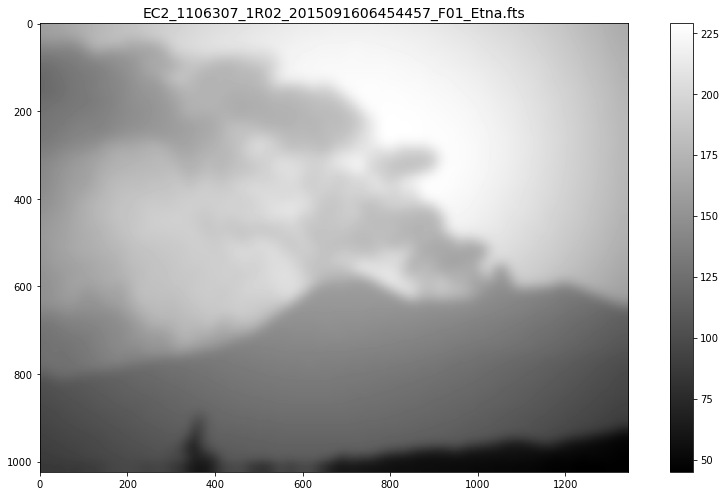

In [27]:
lst.show_current()

These lists are of type ``ImgList``. Similarly, dark and offset image lists
(`DarkImgList` classes) were created using the information stored in the
`DarkOffsetInfo` objects specified in our camera:

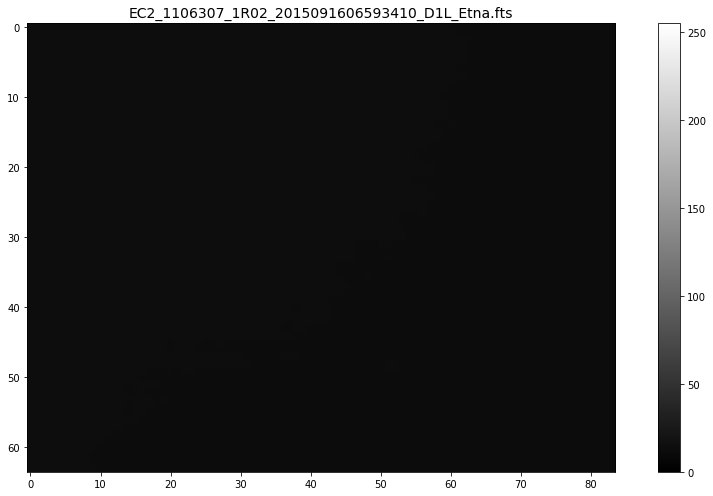

In [28]:
dark_list_low_gain = ds.get_list("dark0")
dark_list_low_gain.show_current(vmin=0, vmax=255)

In [29]:
offset_list_low_gain = ds.get_list("offset0")

You can also easily access all lists, that actually contain images and correspond to one of the ``Filter`` objects:

In [30]:
all_imglists = ds.img_lists_with_data #this is a dictionary
print(all_imglists.keys()) #prints the list / Filter IDs

odict_keys(['on', 'off'])


and similar, all `DarkImgList` objects that contain data:

In [31]:
all_darklists = ds.dark_lists_with_data #this is a dictionary
print(all_darklists.keys()) #prints the list IDs

odict_keys(['offset0', 'offset1', 'dark0', 'dark1'])


If everything works out nicely, you can add the camera as new default using:

In [32]:
try:
    cam.save_as_default()
except KeyError as e:
    print(repr(e))

KeyError('Cam ID conflict: one of the provided IDs already exists in database...')


After saving the camera as new default, you can load it using:

In [33]:
import pyplis
cam = pyplis.Camera(cam_id="ecII_test")
print(cam)

ecII_test, serno. 9999
-------------------------
cam_id: ecII_test
delim: _
time_info_pos: 3
time_info_str: %Y%m%d%H%M%S%f
filter_id_pos: 4
texp_pos: None
texp_unit: 
file_type: fts
main_filter_id: on
meas_type_pos: 4
darkcorr_opt: 0
focal_length: 0.025
pix_height: 4.65e-06
pix_width: 4.65e-06
pixnum_x: 1344
pixnum_y: 1024
reg_shift_off: [0.0, 0.0]
io_opts: {}
image_import_method: None

Dark & offset info
------------------------
ID: offset0, type: offset, acronym: D0L, meas_type_acro: D0L,read_gain: 0
ID: offset1, type: offset, acronym: D0H, meas_type_acro: D0H,read_gain: 1
ID: dark0, type: dark, acronym: D1L, meas_type_acro: D1L,read_gain: 0
ID: dark1, type: dark, acronym: D1H, meas_type_acro: D1H,read_gain: 1

Filters
----------------------
on, type: on (default): nan nm
Default Filter: on

Geometry info
----------------------
lon: None
lat: None
altitude: None
azim: None
azim_err: None
elev: None
elev_err: None
alt_offset: 0.000



Done!